In [1]:
# import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages

In [2]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.10.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.0.5
numpy            : 1.17.0
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.1.1
setuptools       : 49.2.0.post20200714
Cython           : 0.29.21
pytest           : 5.4.3
hypothesis       : None
sphinx           : 3.1.2
blosc            : None
feather          : None
xlsxwriter       : 1.2.9
lxml.etree       : 4.5.2
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.16.1
pandas_datareader: None
bs4              : 4.9.1
bottleneck       : 1.3.2
fastparquet      : None
gcsfs            : None
lxml.etree       : 4

In [3]:
# Read data
data = pd.read_csv("data.csv")

In [4]:
#data preprocessing
#identify missing values
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [5]:
# Drop useless variables
data = data.drop(['Unnamed: 32','id'],axis = 1)

# Reassign target
data.diagnosis.replace(to_replace = dict(M = 1, B = 0), inplace = True)

In [6]:
# View first 5 data
data.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
0         0.2419  ...         25.38          17.33           184.60   
1         0.1812  ...         24.99          23.41           158.80   
2         0.2069  ...         23.57          25.53           152.50   
3         0.2597  ...         14.91          26.50            98.87   
4         0.1809  ...         22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 31 columns]

In [7]:
# describe data
data.describe()

diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  569.000000   569.000000    569.000000      569.000000   569.000000   
mean     0.372583    14.127292     19.289649       91.969033   654.889104   
std      0.483918     3.524049      4.301036       24.298981   351.914129   
min      0.000000     6.981000      9.710000       43.790000   143.500000   
25%      0.000000    11.700000     16.170000       75.170000   420.300000   
50%      0.000000    13.370000     18.840000       86.240000   551.100000   
75%      1.000000    15.780000     21.800000      104.100000   782.700000   
max      1.000000    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count     569.000000  ...    569.000000     569.000000       569.000000   
mean        0.181162  ...     16.269190      25.677223       107.261213   
std         0.027414  ...      4.833242       6.146258        33.602542   
min         0.106000  ...      7.930000      12.020000        50.410000   
25%         0.161900  ...     13.010000      21.080000        84.110000   
50%         0.179200  ...     14.970000      25.410000        97.660000   
75%         0.195700  ...     18.790000      29.720000       125.400000   
max         0.304000  ...     36.040000      49.540000       251.200000   

        area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count   569.000000        569.000000         569.000000       569.000000   
mean    880.583128          0.132369           0.254265         0.272188   
std     569.356993          0.022832           0.157336         0.208624   
min     185.200000          0.071170           0.027290         0.000000   
25%     515.300000          0.116600           0.147200         0.114500   
50%     686.500000          0.131300           0.211900         0.226700   
75%    1084.000000          0.146000           0.339100         0.382900   
max    4254.000000          0.222600           1.058000         1.252000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count            569.000000      569.000000               569.000000  
mean               0.114606        0.290076                 0.083946  
std                0.065732        0.061867                 0.018061  
min                0.000000        0.156500                 0.055040  
25%                0.064930        0.250400                 0.071460  
50%                0.099930        0.282200                 0.080040  
75%                0.161400        0.317900                 0.092080  
max                0.291000        0.663800                 0.207500  

[8 rows x 31 columns]

In [8]:
# divide the first column into 2 datasets
M = data[(data['diagnosis'] != 0)]
B = data[(data['diagnosis'] == 0)]

In [9]:
# plot of count data
trace = go.Bar(x = (len(M), len(B)), y = ['malignant', 'benign'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'red', 'blue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

# plot percentage of data
trace = go.Pie(labels = ['benign','malignant'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['blue', 'red'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [10]:
#identify distribution plot
def plot_distribution(data_select, size_bin) :  
    tmp1 = M[data_select]
    tmp2 = B[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FF0000', '#0000FF']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [11]:
#plot distribution 'mean'
plot_distribution('radius_mean', .5)
plot_distribution('texture_mean', .5)
plot_distribution('perimeter_mean', 7)
plot_distribution('area_mean', 10)
plot_distribution('smoothness_mean', .03)
plot_distribution('compactness_mean', .05)
plot_distribution('concavity_mean', .05)
plot_distribution('concave points_mean', .05)
plot_distribution('symmetry_mean', .05)
plot_distribution('fractal_dimension_mean', .02)

In [12]:
#plot distribution 'se'
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)
plot_distribution('smoothness_se', .005)
plot_distribution('compactness_se', .03)
plot_distribution('concavity_se', .05)
plot_distribution('concave points_se', .005)
plot_distribution('symmetry_se', .01)
plot_distribution('fractal_dimension_se', .001)

In [13]:
#plot distribution 'worst'
plot_distribution('radius_worst', .5)
plot_distribution('texture_worst', .5)
plot_distribution('perimeter_worst', 5)
plot_distribution('area_worst', 10)
plot_distribution('smoothness_worst', .05)
plot_distribution('compactness_worst', .1)
plot_distribution('concavity_worst', .1)
plot_distribution('concave points_worst', .1)
plot_distribution('symmetry_worst', .1)
plot_distribution('fractal_dimension_worst', .01)

In [14]:
#define correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

In [15]:
#plot correlation matrix
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Magma',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

In [16]:
#compare correlation between 2 features
def plot_feat1_feat2(feat1, feat2) :  
    trace0 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#FF0000',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = B[feat1],
        y = B[feat2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#0000FF',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [17]:
#4 samples of positive correlated features
plot_feat1_feat2('perimeter_mean','radius_mean')
plot_feat1_feat2('area_mean','perimeter_mean')
plot_feat1_feat2('radius_worst','area_worst')
plot_feat1_feat2('perimeter_worst','perimeter_mean')

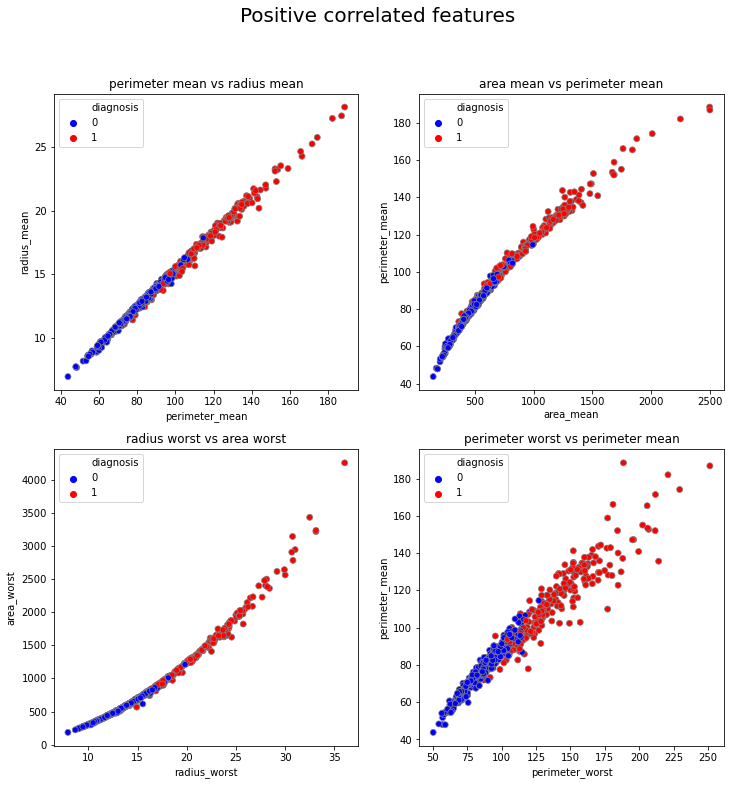

In [18]:
#seaborn version : 

palette ={0 : 'blue', 1 : 'red'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['perimeter_mean'], y = data['radius_mean'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs perimeter mean')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['radius_worst'], y = data['area_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius worst vs area worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['perimeter_worst'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('perimeter worst vs perimeter mean')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()

In [19]:
#4 samples of uncorrelated features
plot_feat1_feat2('symmetry_mean','texture_worst')
plot_feat1_feat2('radius_mean','fractal_dimension_worst')
plot_feat1_feat2('fractal_dimension_worst','area_worst')
plot_feat1_feat2('concavity_mean','texture_se')

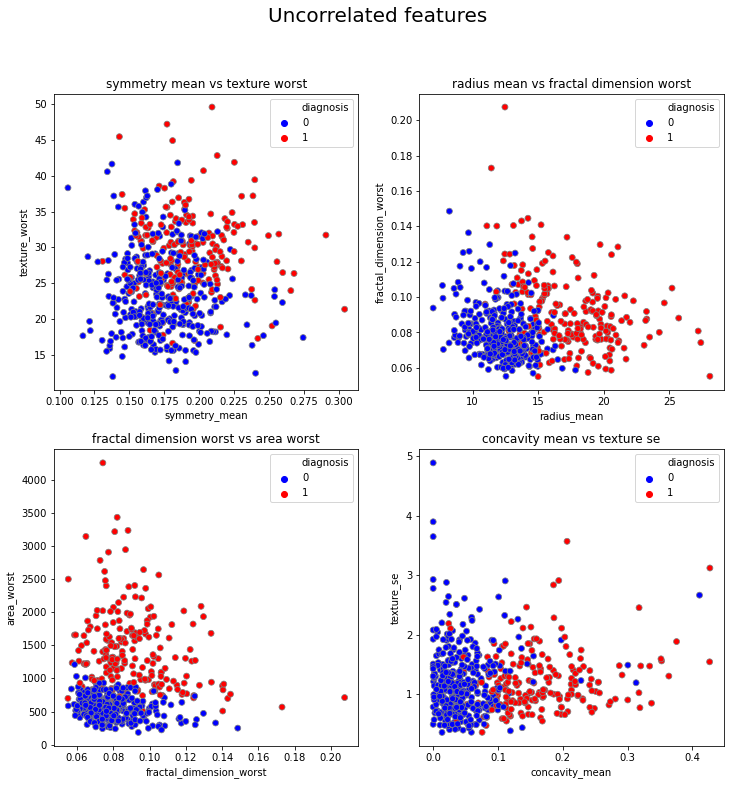

In [20]:
# seaborn version : 
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['symmetry_mean'], y = data['texture_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('symmetry mean vs texture worst')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['fractal_dimension_worst'], y = data['area_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('fractal dimension worst vs area worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['concavity_mean'], y = data['texture_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('concavity mean vs texture se')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

In [21]:
#4 samples of negative correlated features
plot_feat1_feat2('smoothness_se','radius_mean')
plot_feat1_feat2('radius_worst','fractal_dimension_mean')
plot_feat1_feat2('texture_se','symmetry_worst')
plot_feat1_feat2('smoothness_se','radius_worst')

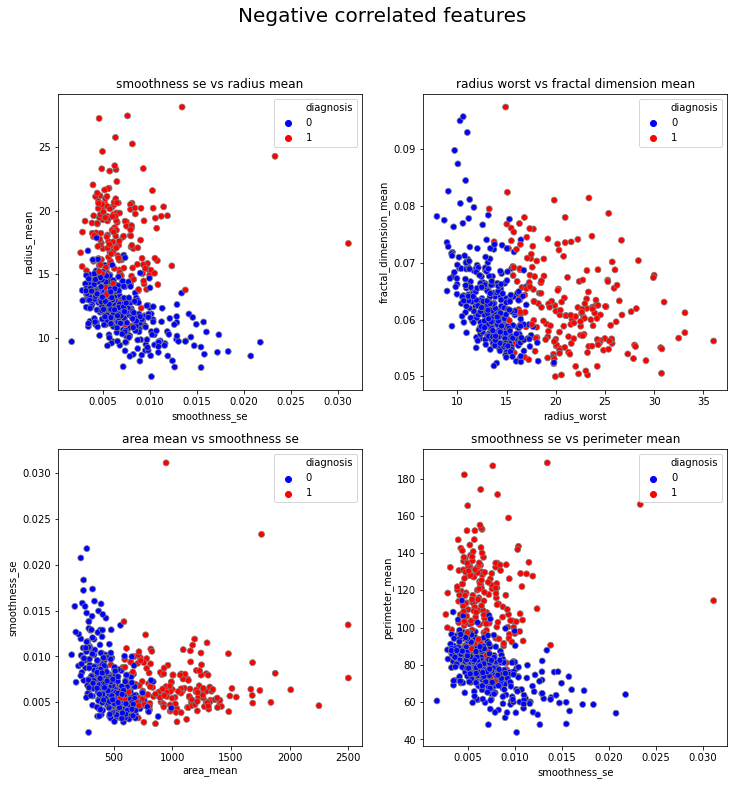

In [22]:
# seaborn version
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['smoothness_se'], y = data['radius_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness se vs radius mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_worst'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius worst vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['smoothness_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['smoothness_se'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

In [23]:
# Define Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Reds) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))

In [24]:
# Define Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [25]:
# Define ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'r--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [26]:
#Define Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
            label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "b",
            label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

In [27]:
# Define cross-validation metrics
def cross_val_metrics(model) :
    scores = ['f1','accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [28]:
#Prepare dataset
# Define X(features) and Y(diagnosis(M or B))
y = np.array(data.diagnosis.tolist())
data1 = data.drop('diagnosis', 1)
X = np.array(data1.values)

In [29]:
# Data standardization
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
# Split data to train and test set
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [31]:
#Logistic Regression
# Find best hyperparameters by logistic regression and GridSearchCV (accuracy)
log_clf = LogisticRegression(random_state = 42)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


The best parameters for using this model is {'C': 1, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.3s finished


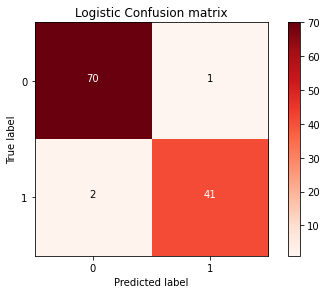

Accuracy  =     0.974
Precision =     0.976
Recall    =     0.953
F1_score  =     0.965


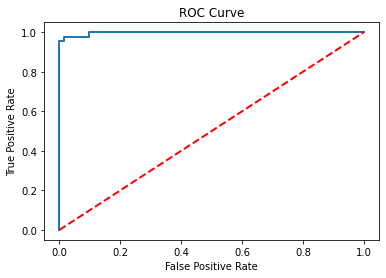

In [32]:
#Logistic Regression with best hyperparameters
CV_log_clf = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)

# Confusion maxtrix & metrics, plot the matrix and show its value
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve, plot ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

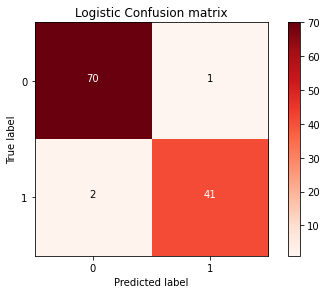

Accuracy  =     0.974
Precision =     0.976
Recall    =     0.953
F1_score  =     0.965


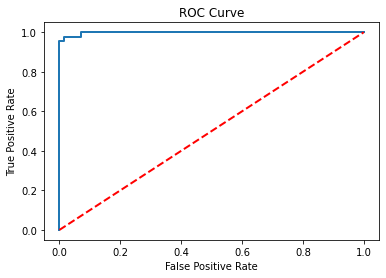

In [33]:
#Logistic regression with Recursive Feature Elimination (RFE), apply RFE to eliminate from 30 to 15 features
log_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics, plot the matrix and show its value
cm = confusion_matrix(y_test, y_pred)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Confusion matrix')
plt.show()

show_metrics()

# ROC curve, plot ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc()

In [34]:
# support and ranking of RFE
print(selector.support_)
print(selector.ranking_)

[ True False False  True False False False  True False False  True False
  True  True False  True False False False False  True  True  True  True
  True False  True  True  True False]
[ 1  4  5  1 15  2  3  1  9 14  1 11  1  1  8  1 12 10  6  7  1  1  1  1
  1 16  1  1  1 13]


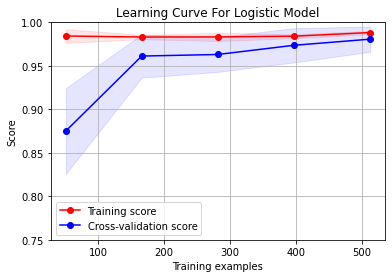

In [35]:
#Learning curve of Logistic Regression with best hyperparameter
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.75,1), 10)
plt.savefig('7')
plt.show()

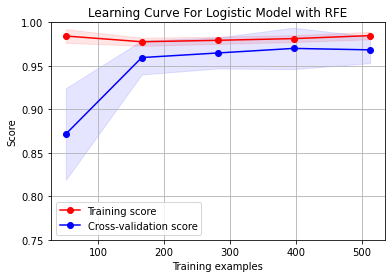

In [36]:
#Learning curve of Logistic Regression with RFE
plot_learning_curve(selector, 'Learning Curve For Logistic Model with RFE', X, y, (0.75,1), 10)
plt.savefig('8')
plt.show()

In [37]:
# Cross-validation metrics of Logistic Regression 
cross_log = cross_val_metrics(CV_log_clf)

[f1] : 0.97360 (+/- 0.00937)
[accuracy] : 0.98069 (+/- 0.00654)
[precision] : 0.98582 (+/- 0.01159)
[recall] : 0.96224 (+/- 0.02426)


In [38]:
# Cross-validation metrics of Logistic Regression with RFE
cross_selector = cross_val_metrics(selector)

[f1] : 0.95453 (+/- 0.01531)
[accuracy] : 0.96664 (+/- 0.01160)
[precision] : 0.97153 (+/- 0.02268)
[recall] : 0.93876 (+/- 0.02403)


Recall w/ threshold = 0.08 : 1.0
Recall w/ threshold = 0.1 : 0.9767441860465116
Recall w/ threshold = 0.2 : 0.9767441860465116
Recall w/ threshold = 0.3 : 0.9767441860465116
Recall w/ threshold = 0.4 : 0.9767441860465116
Recall w/ threshold = 0.5 : 0.9534883720930233


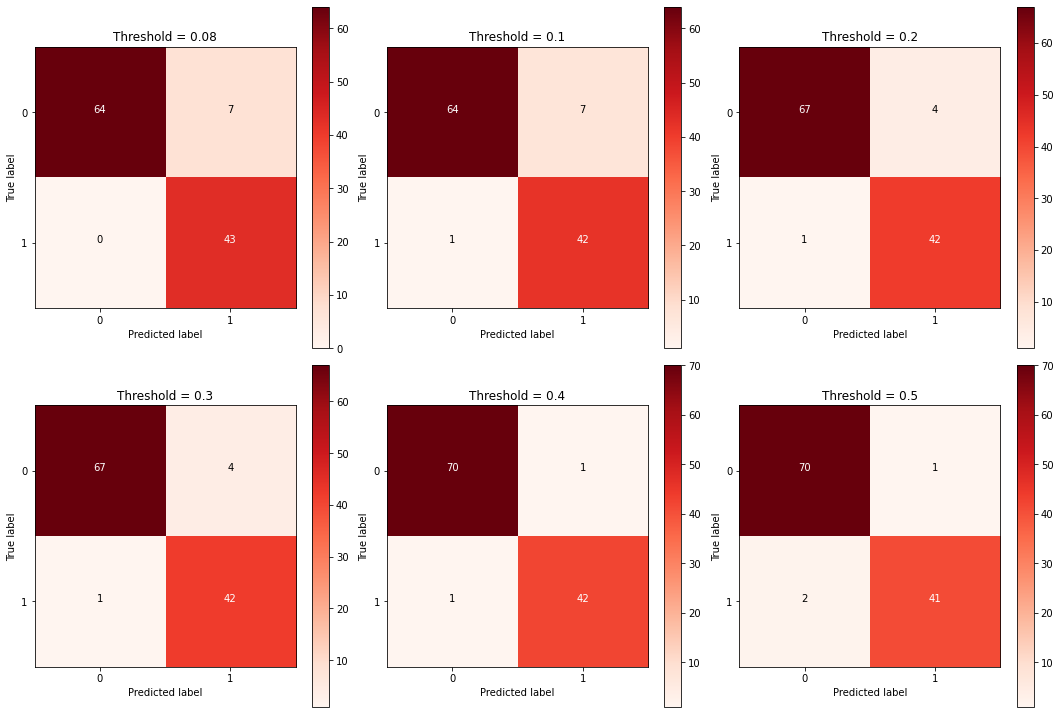

In [39]:
# Select threshold for 100% recall
thresholds_adj = [0.08,0.1,0.2,0.3,0.4,0.5]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 

In [40]:
# Prediction with recall = 100%
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.08
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics()

Accuracy  =     0.939
Precision =     0.860
Recall    =     1.000
F1_score  =     0.925
